# Oversmoothing Analysis of Node Classification

### Setup

In [1]:
import os

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.utils import add_remaining_self_loops, degree
from torch_scatter import scatter
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool, GCNConv, GATConv, SimpleConv
from torch_geometric.datasets import HeterophilousGraphDataset
from torch_geometric.loader import DataLoader
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 1) Find and Download Datasets for Node Classification dataset link

***Roman Empire***

* Based on the Roman Empire article from Wikipedia
* Each node corresponds to a word in the text
* Each word is connected to another if the word follows or there is a dependency within the sentence
* The class of the node is its syntactic role found using spaCy
* Node features are fastText word embeddings

In [2]:
rome = HeterophilousGraphDataset(root='data/', name='Roman-empire')

***Amazon Ratings***

* Nodes are products
* Edges connect products frequently bought together
* Predict binned average rating
* Features are mean of text embeddings of product descriptions

In [11]:
amazon = HeterophilousGraphDataset(root='data/', name='Amazon-ratings')

***Minesweeper***

* 100x100 grid
* Each cell is connected to its eight neighbors
* Mines vs not mines
  * Binary classes
  * 20% are mines
* Node features are one-hot-encoded numbers of neighboring mines

In [3]:
minesweeper = HeterophilousGraphDataset(root='data/', name='Minesweeper')

***Tolokers***

In [8]:
tolo = HeterophilousGraphDataset(root='data/', name='Tolokers')

***Questions***

In [9]:
questions = HeterophilousGraphDataset(root='data/', name='Questions')

### 2) Code GNN-based models and obtain node classification performance
* Define GCN
* Get baseline results

In [68]:
class GAT(torch.nn.Module):
    def __init__(
            self, 
            in_channels,
            conv_channels: list,
            mlp_channels: list,
            out_channels,
            heads=4,
            concat=True
        ):
        super(GAT, self).__init__()

        self.n_conv_layers = len(conv_channels)
        self.n_mlp_layers = len(mlp_channels)

        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(p=0.4)

        concat_heads = heads if concat else 1

        self.convs = nn.ModuleList([
            GATConv(in_channels, conv_channels[0], heads, concat=concat),
            *[GATConv(conv_channels[i - 1] * concat_heads, conv_channels[i], heads, concat=concat)
              for i in range(1, self.n_conv_layers)],
            GATConv(conv_channels[-1] * concat_heads, mlp_channels[0], heads, concat=concat),
        ])

        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(conv_channels[0] * concat_heads),
            *[nn.BatchNorm1d(conv_channels[i] * concat_heads) for i in range(1, self.n_conv_layers)],
            nn.BatchNorm1d(mlp_channels[0] * concat_heads),
        ])

        self.projections = nn.ModuleList([
            nn.Linear(in_channels + conv_channels[0] * concat_heads, conv_channels[0] * concat_heads),
            *[nn.Linear(conv_channels[i - 1] * concat_heads + conv_channels[i] * concat_heads, conv_channels[i] * concat_heads)
              for i in range(1, self.n_conv_layers)],
            nn.Linear(conv_channels[-1] * concat_heads + mlp_channels[0] * concat_heads, mlp_channels[0] * concat_heads),
        ])

        self.input_projection = nn.Linear(in_channels, mlp_channels[0] * concat_heads)

        self.fc1 = nn.Linear(mlp_channels[0] * concat_heads, mlp_channels[1])
        self.fc2 = nn.Linear(mlp_channels[1], out_channels)
        
    def forward(self, x, edge_index, return_emb=False):
        embeddings = []

        start = x
        
        skip = x

        for i, conv in enumerate(self.convs):
            # Conv + batch norm
            x = conv(x, edge_index)
            if return_emb:
                embeddings.append(x)
            x = self.batch_norms[i](x)

            # Skip connections + linear projection
            x = torch.cat([x, skip], dim=1)
            x = self.projections[i](x)
            skip = x

            # Activation + dropout
            x = self.gelu(x)
            x = self.dropout(x)

        # Residual
        start = self.input_projection(start)
        # x = torch.cat([start, x])
        x = start + x

        # MLP
        x = self.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)

        if return_emb:
            return output, embeddings

        return output

In [85]:
class Trainer:
    def __init__(self, model, dataset, split_index=0):
        self.model = model
        self.dataset = dataset
        self.loader = DataLoader(dataset, batch_size=1) #shuffle=True)

        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-2)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode="min", factor=0.5, patience=50)
        self.criterion = nn.NLLLoss()

        self.train_mask = dataset.train_mask[:, split_index]
        self.val_mask = dataset.val_mask[:, split_index]
        self.test_mask = dataset.test_mask[:, split_index]

    def train(self):
        # Training loop
        self.model.train()
        self.optimizer.zero_grad()
        out = self.model(self.dataset.x, self.dataset.edge_index)
        loss = self.criterion(out[self.train_mask], self.dataset.y[self.train_mask])
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def evaluate(self):
        # Evaluation loop
        self.model.eval()
        with torch.no_grad():
            logits = self.model(self.dataset.x, self.dataset.edge_index)
            pred = logits.argmax(dim=1)
            accs = []
            for mask in [self.train_mask, self.val_mask, self.test_mask]:
                acc = (pred[mask] == self.dataset.y[mask]).sum().item() / mask.sum().item()
                accs.append(acc)
        return accs

    def run(self, num_epochs):
        # Training process
        for epoch in range(num_epochs):
            loss = self.train()
            train_acc, val_acc, test_acc = self.evaluate()
            if epoch % 50 == 0 or epoch == (num_epochs - 1):
                print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, '
                    f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

    def predict(self):
        batch = next(iter(self.loader))
        with torch.no_grad():
            logits, embeddings = self.model(batch.x, batch.edge_index, return_emb=True)

        predictions = logits.argmax(dim=1)

        return predictions, embeddings
    
    def eval(self):
        predictions, _ = self.predict()

        test_y = self.dataset.y[self.criteriontrainer.test_mask]

        acc = (test_y == predictions[self.trainer.test_mask]).sum() / len(test_y)
        
        return acc
                
    def save_weights(self, path=None):
        if path is None:
            path = f"models/gcn_{self.dataset.name}.pth"

        # Save model
        torch.save(self.model.state_dict(), path)

    def load_weights(self, path=None):
        if path is None:
            path = f"models/gcn_{self.dataset.name}.pth"

        self.model.load_state_dict(torch.load(path, weights_only=True))

    def get_num_params(self):
        return sum(p.numel() for p in self.model.parameters())

### 3) Change the Message-passing layer and obtain performance for each layer
* Test different message-passing layers
* Test different number of layers

In [71]:
all_results = {
    "GAT": dict(),
}

***Rome***

In [ ]:
dataset = rome

conv_channels_list = [512]
mlp_channels_list = [128, 128]
num_heads = 8

model = GAT(
    in_channels=dataset.num_node_features,
    conv_channels=conv_channels_list,
    mlp_channels=mlp_channels_list,
    out_channels=dataset.num_classes,
    heads=num_heads,
    concat=True
).to(device)

trainer = Trainer(model, dataset)

trainer.run(100)

Epoch 000, Loss: 0.3105, Train Acc: 0.9624, Val Acc: 0.6863, Test Acc: 0.6708
Epoch 050, Loss: 0.2393, Train Acc: 0.9798, Val Acc: 0.6842, Test Acc: 0.6733
Epoch 099, Loss: 0.1991, Train Acc: 0.9846, Val Acc: 0.6837, Test Acc: 0.6684


In [83]:
predictions, emb = trainer.predict()

test_y = trainer.dataset.y[trainer.test_mask]

acc = (test_y == predictions[trainer.test_mask]).sum() / len(test_y)
acc

tensor(0.6684, device='cuda:0')

### 4) Analyze the relationship between the number of message-passing layers and the node classification performance
* Visualize oversmoothing

In [ ]:
class Analyzer:
    def __init__(self):
        self.tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, max_iter=1000)

    def fit_tsne(self, data):
        self.tsne.

In [ ]:
# Load model from file
model = GAT(
    in_channels=dataset.num_node_features,
    conv_channels=conv_channels_list,
    mlp_channels=mlp_channels_list,
    out_channels=dataset.num_classes,
    heads=num_heads,
).to(device)

model.load_state_dict(torch.load(weights_path, weights_only=True))

<All keys matched successfully>

In [55]:
loader = DataLoader(dataset, batch_size=1) #shuffle=True)

batch = next(iter(loader))
with torch.no_grad():
    logits, embeddings = model(batch.x, batch.edge_index, return_emb=True)

predictions = logits.argmax(dim=1)
predictions

tensor([10, 10,  6,  ...,  4,  4, 12], device='cuda:0')

In [56]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, max_iter=1000)

emb_2d = []

for i, emb in enumerate(embeddings):
    emb_2d.append(tsne.fit_transform(emb.cpu().numpy()))

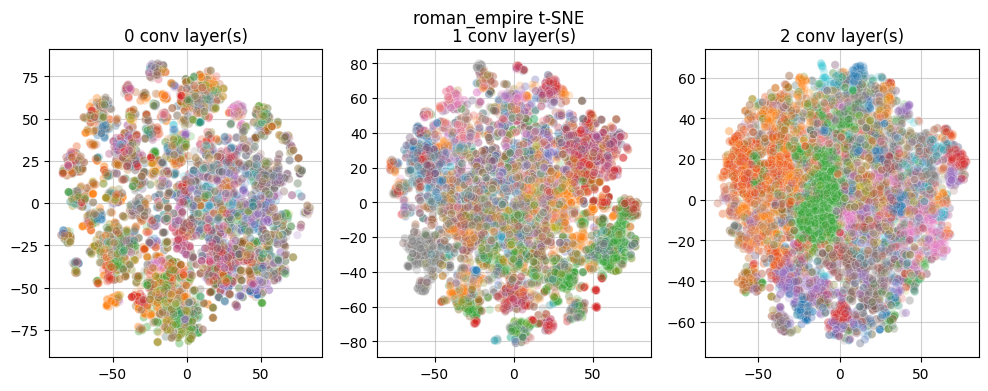

In [ ]:

def plot_tsne(emb_2d, legend=True):
    n_emb = len(emb_2d)

    labels = dataset.y.cpu()

    fig, axes = plt.subplots(1, n_emb, figsize=(12, 4))

    for i, ax in enumerate(axes):

        end = 10000
        data = emb_2d[i][:end]

        x = data[:, 0]
        y = data[:, 1]

        sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels[:end], ax=ax, alpha=0.2, palette="tab10")
                        
        ax.set_title(f"{i + 1} conv layer(s)")
        if not legend:
            ax.get_legend().remove()
        ax.set_axisbelow(True)
        ax.grid(alpha=0.6)

    plt.suptitle(f"{dataset.name} t-SNE")

    plt.show()

plot_tsne(emb_2d, legend=False)